In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import f1_score
import pandas as pd
import  numpy as np
from tqdm import notebook

# Loading DataSet

In [2]:
data_dir = './A_05_Part_02_Dataset'

img_transforms = transforms.Compose([transforms.Resize([224, 224]),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

#img_transforms = transforms.Compose([transforms.Resize([224, 224]),
#                                     transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + '/Train', transform = img_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test',  transform = img_transforms)
val_data = datasets.ImageFolder(data_dir + '/Validation', transform = img_transforms)


#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=8, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


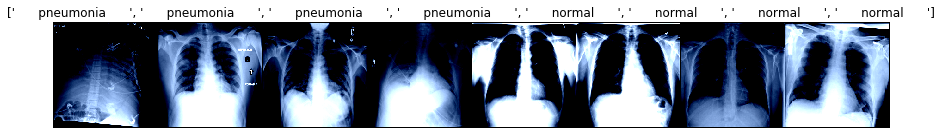

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    fig = plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=["      "+class_names[x]+"      " for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

## Model Tunner

In [4]:
# Curves[0] = Loss Curve, Curves[1] = ValError Curve, Curves[2] = ValAcc Curve, Curves[3] = TrainAcc
# Curves = [[], [], [], []]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
gamma = 1.5

#"""
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=1.5):
        super().__init__()
        self.gamma = gamma

    def forward(self, y_pred, y_true):
        lf = nn.BCEWithLogitsLoss(reduction="none")
        loss = lf(y_pred,y_true)
        pt = torch.exp(-loss)
        Floss = ((1-pt)**gamma)*loss
        #loss = -( torch.sum( ((1-pt)**gamma) * torch.log(pt)) )/y_pred.shape[0]
        return (Floss.sum())/y_pred.shape[0]
"""

def FocalLoss(y_pred, y_true):
    p = torch.sigmoid(y_pred)
    pt = torch.zeros_like(p)
    pt[:] = (1 - p)*(1-y_true) + p*y_true
    loss = -( torch.sum( ((1-pt)**gamma) * torch.log(pt)) )/y_pred.shape[0]
    return loss

"""

'\n\ndef FocalLoss(y_pred, y_true):\n    p = torch.sigmoid(y_pred)\n    pt = torch.zeros_like(p)\n    pt[:] = (1 - p)*(1-y_true) + p*y_true\n    loss = -( torch.sum( ((1-pt)**gamma) * torch.log(pt)) )/y_pred.shape[0]\n    return loss\n\n'

In [6]:
def Train(Model, savePath, Epochs, Curves, focalLoss = False):
    
    Model.to(device)
    Model.train()

    for epoch in notebook.trange(Epochs):  # loop over the dataset multiple times

        train_correct = 0
        train_total = 0
        running_loss = 0.0
        
        with notebook.tqdm(trainloader , leave=False, desc="Training ", mininterval=0.5 ) as TI:
            for data in TI:
                # get the inputs
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                labels = torch.nn.functional.one_hot(labels, num_classes=len(class_names))*1.0
                labels[labels[:, 0]==1 , 2] = 1 

                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward + backward + optimize
                outputs = Model(inputs)               #----> forward pass
                loss = criterion(outputs, labels)     #----> compute loss
                if(focalLoss):
                    loss = FocalLoss(outputs, labels)
                loss.backward()                       #----> backward pass
                optimizer.step()                      #----> weights update

                # print and saving statistics
                running_loss += loss.item()
                predicted = (torch.sigmoid(outputs.data) >= 0.5) * 1
                
                train_total += labels.size(0)
                train_correct += ((predicted[:,0] == labels[:,0]) * (predicted[:,1] == labels[:,1]) * (predicted[:,2] == labels[:,2])).sum().item()
                
                TI.set_postfix(Loss = (loss.data.item()), Accuracy = train_correct/train_total)
                
        acc, _, __ = Accuracy(Model, valloader)
        
        print(f"Epoch {epoch+1}, Loss = {running_loss}, ValAcc = {acc}, ValError = {1-acc}")
        
        Curves[0].append(running_loss)
        Curves[1].append(1-acc)
        
        Curves[2].append(train_correct/train_total)
        Curves[3].append(acc)
        
        torch.save(Model.state_dict(), savePath)
    
    print('Finished Training')
    
def Accuracy(Model, dataLoader):
    
    Model.to(device)
    predictions = []
    ground_truth = []
    correct = 0
    total = 0
    with torch.no_grad():
        with notebook.tqdm(dataLoader , leave=False, desc="Predicting ", mininterval=0.5 ) as TI:
            for data in TI:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                
                labels = torch.nn.functional.one_hot(labels, num_classes=len(class_names))*1.0
                labels[labels[:, 0]==1 , 2] = 1 

                outputs = Model(images)
                
                predicted = (torch.sigmoid(outputs.data) >= 0.5) * 1

                total += labels.size(0)
                correct += ((predicted[:,0] == labels[:,0]) * (predicted[:,1] == labels[:,1]) * (predicted[:,2] == labels[:,2])).sum().item()
                
                predictions.append(predicted)
                ground_truth.append(labels)
                
                TI.set_postfix(Accuracy = (correct / total))
        
    return (correct / total), torch.cat(predictions), torch.cat(ground_truth)
    


In [7]:
#Taken From CV Assignment 4
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    
    title = 'Confusion Matrix'

    # Compute confusion matrix
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    
    print('Confusion Matrix')
    
    Aclasses = [[classes[1]+ "+" +classes[2], classes[0]],
                [classes[0]+ "+" +classes[2], classes[1]],
                [classes[0]+ "+" +classes[1],classes[2]]]
    
    for cm,classes in zip(mcm, Aclasses):
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        
    return 

def PlotCurves(Curves):
    
    ## Train Val Loss Curves
    plt.plot(np.arange(len(Curves[0])), np.array(Curves[0])/299, label="Training Avg Loss")
    plt.plot(np.arange(len(Curves[1])), Curves[1], label="Validation Error")
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.title("Training and Validation Loss Curves.")
    plt.show()
    
    
    # Train Val Acc Curves
    plt.plot(np.arange(len(Curves[2])), Curves[2], label="Training Accuracy")
    plt.plot(np.arange(len(Curves[3])), Curves[3], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy Curves.")
    plt.show()


# Fine Tuning VGG-16

### Changing the Model's FC Layers

In [9]:
vgg16 = models.vgg16(pretrained=True)

features = list(vgg16.classifier.children())[:-1]

num_features = vgg16.classifier[3].out_features

features.extend([nn.Linear(num_features, len(class_names), bias=True)])

vgg16.classifier = nn.Sequential(*features)
print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)


### VGG Tunning BCELoss

Epoch 1, Loss = 233.65651793405414, ValAcc = 0.8471337579617835, ValError = 0.15286624203821653


Epoch 2, Loss = 148.05948458332568, ValAcc = 0.8439490445859873, ValError = 0.1560509554140127


Epoch 3, Loss = 127.55905705783516, ValAcc = 0.8773885350318471, ValError = 0.1226114649681529


Epoch 4, Loss = 116.03883504029363, ValAcc = 0.8901273885350318, ValError = 0.10987261146496818


Epoch 5, Loss = 106.2398071908392, ValAcc = 0.9044585987261147, ValError = 0.09554140127388533


Epoch 6, Loss = 98.31314286822453, ValAcc = 0.9060509554140127, ValError = 0.0939490445859873


Epoch 7, Loss = 89.99228562577628, ValAcc = 0.910828025477707, ValError = 0.08917197452229297


Epoch 8, Loss = 82.86772035760805, ValAcc = 0.9171974522292994, ValError = 0.08280254777070062


Epoch 9, Loss = 78.09769909223542, ValAcc = 0.9092356687898089, ValError = 0.09076433121019112


Epoch 10, Loss = 71.5930477543734, ValAcc = 0.9267515923566879, ValError = 0.07324840764331209


Epoch 11, Loss = 64.96037151291966, ValAcc = 0.9203821656050956, ValError = 0.07961783439490444


Epoch 12, Loss = 63.41226112830918, ValAcc = 0.9028662420382165, ValError = 0.09713375796178347


Epoch 13, Loss = 51.988467730232514, ValAcc = 0.9267515923566879, ValError = 0.07324840764331209


Epoch 14, Loss = 49.138665495906025, ValAcc = 0.9171974522292994, ValError = 0.08280254777070062


Epoch 15, Loss = 43.82749743689783, ValAcc = 0.928343949044586, ValError = 0.07165605095541405


Epoch 16, Loss = 41.37763772155449, ValAcc = 0.9251592356687898, ValError = 0.07484076433121023


Epoch 17, Loss = 32.279672594508156, ValAcc = 0.9171974522292994, ValError = 0.08280254777070062


Epoch 18, Loss = 27.804333236323146, ValAcc = 0.9140127388535032, ValError = 0.0859872611464968


Epoch 19, Loss = 26.688170772773447, ValAcc = 0.9203821656050956, ValError = 0.07961783439490444


Epoch 20, Loss = 21.808764841247466, ValAcc = 0.9235668789808917, ValError = 0.07643312101910826

Finished Training


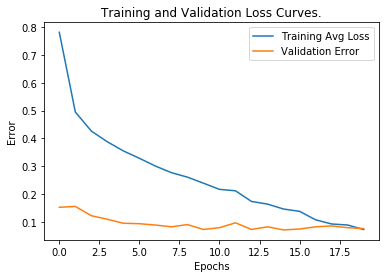

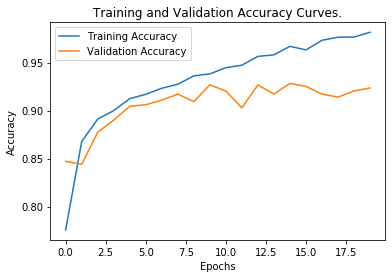

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
Epochs = 20
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(vgg16.parameters(), lr=0.00007, momentum=0.9)

VGG_Curves = [[],[],[],[]]

Train(vgg16, "vgg16_BCEloss.pth", Epochs, VGG_Curves)
PlotCurves(VGG_Curves)

vgg16.to("cpu")


After FC Layers Fine Tunning the Accuracy is 98.31%
F1 Score =  [0.90463215 0.99285983 0.98799547]
Confusion Matrix


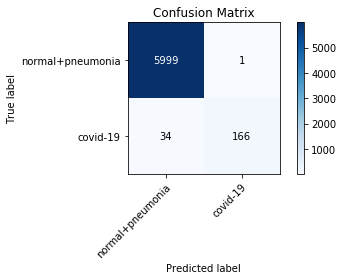

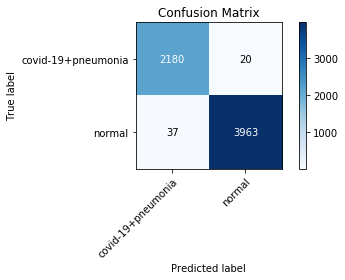

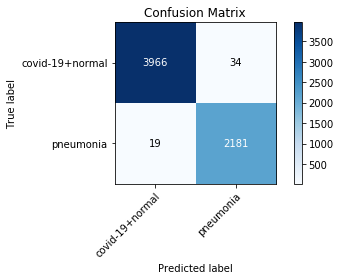

In [40]:
acc, predictions, grndTruth = Accuracy(vgg16, trainloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu"), average=None))

plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
vgg16.to("cpu")

torch.cuda.empty_cache()

After FC Layers Fine Tunning the Accuracy is 92.68%
Confusion Matrix
F1 Score =  [0.79166667 0.95619524 0.91666667]


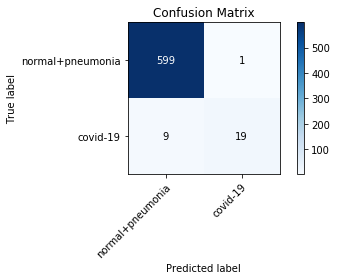

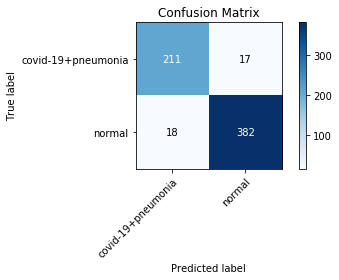

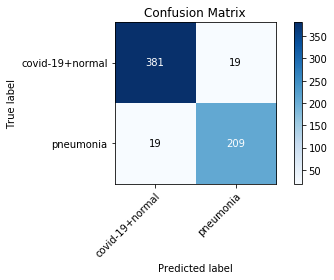

In [39]:
acc, predictions, grndTruth = Accuracy(vgg16, valloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu"), average=None))
vgg16.to("cpu")

torch.cuda.empty_cache()

### VGG Tunning with Focal Loss

In [23]:
vgg16 = models.vgg16(pretrained=True)

features = list(vgg16.classifier.children())[:-1]

num_features = vgg16.classifier[3].out_features

features.extend([nn.Linear(num_features, len(class_names), bias=True)])

vgg16.classifier = nn.Sequential(*features)
print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)


Epoch 1, Loss = 237.65431195497513, ValAcc = 0.8487261146496815, ValError = 0.1512738853503185


Epoch 2, Loss = 157.1047417735681, ValAcc = 0.8805732484076433, ValError = 0.11942675159235672


Epoch 3, Loss = 133.5114682884887, ValAcc = 0.8805732484076433, ValError = 0.11942675159235672


Epoch 4, Loss = 119.84255399554968, ValAcc = 0.8885350318471338, ValError = 0.11146496815286622


Epoch 5, Loss = 109.2160548332613, ValAcc = 0.9012738853503185, ValError = 0.0987261146496815


Epoch 6, Loss = 94.08091301377863, ValAcc = 0.9140127388535032, ValError = 0.0859872611464968


Epoch 7, Loss = 85.36621952336282, ValAcc = 0.9219745222929936, ValError = 0.07802547770700641


Epoch 8, Loss = 75.65693905449007, ValAcc = 0.9235668789808917, ValError = 0.07643312101910826


Epoch 9, Loss = 65.33003810845548, ValAcc = 0.9235668789808917, ValError = 0.07643312101910826


Epoch 10, Loss = 58.305322268541204, ValAcc = 0.9299363057324841, ValError = 0.07006369426751591


Epoch 11, Loss = 50.2470185655402, ValAcc = 0.9203821656050956, ValError = 0.07961783439490444


Epoch 12, Loss = 43.45396055781748, ValAcc = 0.9363057324840764, ValError = 0.06369426751592355


Epoch 13, Loss = 35.122082168323686, ValAcc = 0.9124203821656051, ValError = 0.08757961783439494


Epoch 14, Loss = 28.895234754170815, ValAcc = 0.9394904458598726, ValError = 0.060509554140127375


Epoch 15, Loss = 19.923107681097463, ValAcc = 0.9363057324840764, ValError = 0.06369426751592355


Epoch 16, Loss = 15.21764351127058, ValAcc = 0.9331210191082803, ValError = 0.06687898089171973


Epoch 17, Loss = 18.12538787106405, ValAcc = 0.9299363057324841, ValError = 0.07006369426751591


Epoch 18, Loss = 9.775683115182346, ValAcc = 0.9267515923566879, ValError = 0.07324840764331209


Epoch 19, Loss = 9.623912886421977, ValAcc = 0.9442675159235668, ValError = 0.055732484076433164


Epoch 20, Loss = 8.70455581380861, ValAcc = 0.9394904458598726, ValError = 0.060509554140127375

Finished Training


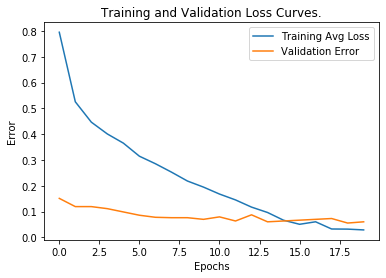

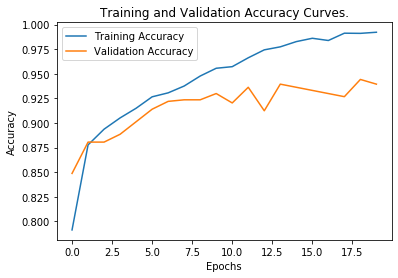

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:

Epochs = 20
criterion = nn.BCEWithLogitsLoss()
criterion = FocalLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.00007, momentum=0.9)

VGG_Curves = [[],[],[],[]]

Train(vgg16, "vgg16_focalloss1.pth", Epochs, VGG_Curves, focalLoss=False)
PlotCurves(VGG_Curves)

vgg16.to("cpu")


After FC Layers Fine Tunning the Accuracy is 92.83%
F1 Score =  [0.84       0.95619524 0.9254386 ]
Confusion Matrix


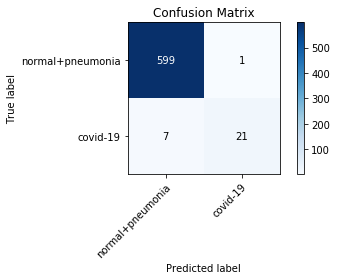

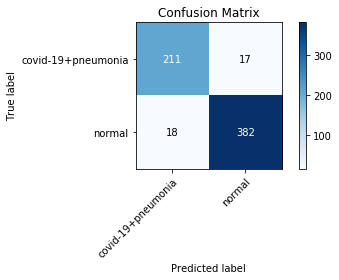

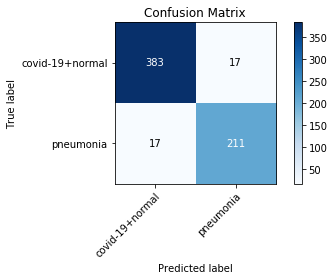

In [25]:
acc, predictions, grndTruth = Accuracy(vgg16, valloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu"), average=None))

plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
vgg16.to("cpu")

torch.cuda.empty_cache()

After FC Layers Fine Tunning the Accuracy is 99.79%
F1 Score =  [0.98       0.99949987 0.99954525]
Confusion Matrix


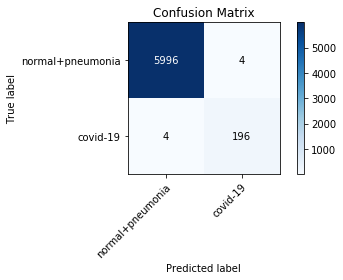

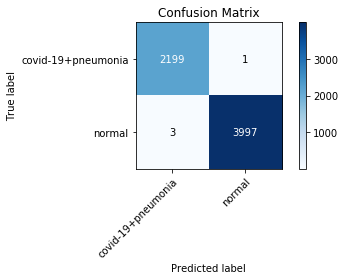

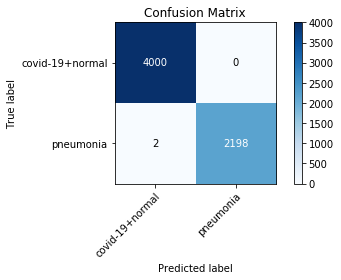

In [26]:
acc, predictions, grndTruth = Accuracy(vgg16, trainloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu"), average=None))

plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
vgg16.to("cpu")

torch.cuda.empty_cache()

# Fine Tunning ResNet-18

### With out Focal Loss

In [12]:
resnet18 = models.resnet18(pretrained = True)

in_features = resnet18.fc.in_features
    
resnet18.fc = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(inplace=True), nn.Dropout(), nn.Linear(256, len(class_names)))

resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1, Loss = 386.51901429891586, ValAcc = 0.6337579617834395, ValError = 0.36624203821656054


Epoch 2, Loss = 300.87311214208603, ValAcc = 0.732484076433121, ValError = 0.26751592356687903


Epoch 3, Loss = 249.9098222181201, ValAcc = 0.7961783439490446, ValError = 0.20382165605095537


Epoch 4, Loss = 216.9065871015191, ValAcc = 0.8248407643312102, ValError = 0.17515923566878977


Epoch 5, Loss = 196.19092160090804, ValAcc = 0.8535031847133758, ValError = 0.14649681528662417


Epoch 6, Loss = 177.22363566607237, ValAcc = 0.8646496815286624, ValError = 0.1353503184713376


Epoch 7, Loss = 165.1134696379304, ValAcc = 0.8535031847133758, ValError = 0.14649681528662417


Epoch 8, Loss = 154.89663963392377, ValAcc = 0.85828025477707, ValError = 0.14171974522292996


Epoch 9, Loss = 151.6327508855611, ValAcc = 0.8726114649681529, ValError = 0.1273885350318471


Epoch 10, Loss = 144.89707716740668, ValAcc = 0.8614649681528662, ValError = 0.13853503184713378


Epoch 11, Loss = 135.44497315958142, ValAcc = 0.8789808917197452, ValError = 0.12101910828025475


Epoch 12, Loss = 126.45173844043165, ValAcc = 0.8630573248407644, ValError = 0.13694267515923564


Epoch 13, Loss = 121.20868311077356, ValAcc = 0.8678343949044586, ValError = 0.13216560509554143


Epoch 14, Loss = 124.9289292730391, ValAcc = 0.8757961783439491, ValError = 0.12420382165605093


Epoch 15, Loss = 113.11812253575772, ValAcc = 0.8853503184713376, ValError = 0.1146496815286624


Epoch 16, Loss = 114.04049923364073, ValAcc = 0.8821656050955414, ValError = 0.11783439490445857


Epoch 17, Loss = 104.65915935952216, ValAcc = 0.8757961783439491, ValError = 0.12420382165605093


Epoch 18, Loss = 100.17736619245261, ValAcc = 0.893312101910828, ValError = 0.106687898089172


Epoch 19, Loss = 95.85305952187628, ValAcc = 0.8742038216560509, ValError = 0.12579617834394907


Epoch 20, Loss = 89.03271011915058, ValAcc = 0.8869426751592356, ValError = 0.11305732484076436

Finished Training


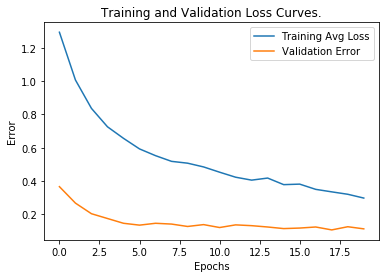

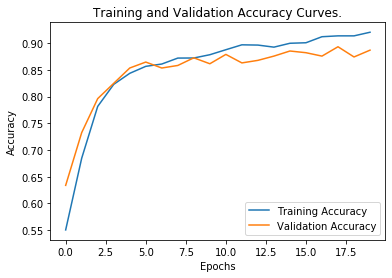

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
Epochs = 20
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.00007, momentum=0.9)

ResNet_Curves = [[],[],[],[]]

Train(resnet18, "resnet18_BCEloss1.pth", Epochs, ResNet_Curves)
PlotCurves(ResNet_Curves)
resnet18.to("cpu")

After FC Layers Fine Tunning the Accuracy is 89.01%
F1 Score =  [0.         0.94261294 0.89449541]
Confusion Matrix


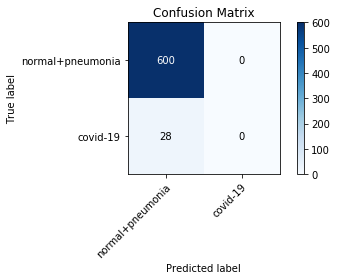

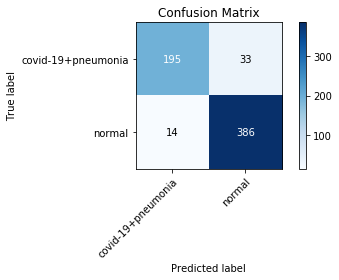

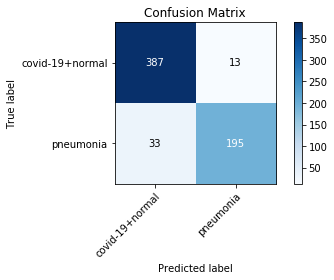

In [14]:
acc, predictions, grndTruth = Accuracy(resnet18, valloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))

print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu"), average=None))


plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
resnet18.to("cpu")

torch.cuda.empty_cache()

After FC Layers Fine Tunning the Accuracy is 92.55%
F1 Score =  [0.         0.96951673 0.94447015]
Confusion Matrix


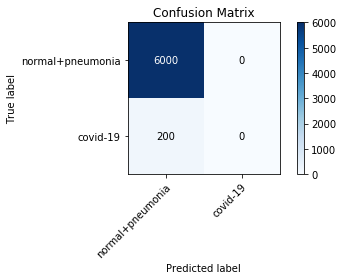

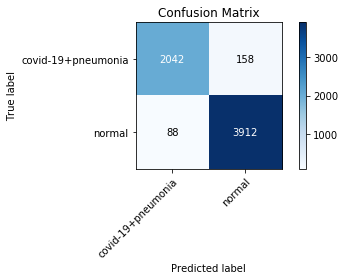

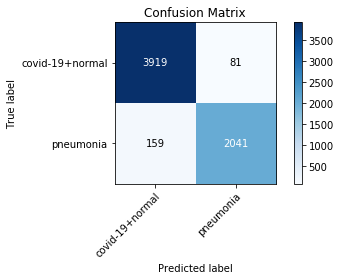

In [15]:
acc, predictions, grndTruth = Accuracy(resnet18, trainloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu"), average=None))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)
resnet18.to("cpu")

torch.cuda.empty_cache()

### With Focal Loss

In [16]:
resnet18 = models.resnet18(pretrained = True)

in_features = resnet18.fc.in_features
    
resnet18.fc = nn.Sequential(nn.Linear(in_features, 256), nn.ReLU(inplace=True), nn.Dropout(), nn.Linear(256, len(class_names)))

resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1, Loss = 311.71695102006197, ValAcc = 0.7945859872611465, ValError = 0.2054140127388535


Epoch 2, Loss = 206.0276338122785, ValAcc = 0.8375796178343949, ValError = 0.16242038216560506


Epoch 3, Loss = 168.69226709380746, ValAcc = 0.8550955414012739, ValError = 0.14490445859872614


Epoch 4, Loss = 149.6597905792296, ValAcc = 0.85828025477707, ValError = 0.14171974522292996


Epoch 5, Loss = 133.43246528320014, ValAcc = 0.8694267515923567, ValError = 0.13057324840764328


Epoch 6, Loss = 124.21602044440806, ValAcc = 0.8694267515923567, ValError = 0.13057324840764328


Epoch 7, Loss = 109.86049069929868, ValAcc = 0.8678343949044586, ValError = 0.13216560509554143


Epoch 8, Loss = 103.06019911542535, ValAcc = 0.89171974522293, ValError = 0.10828025477707004


Epoch 9, Loss = 88.14411575067788, ValAcc = 0.8726114649681529, ValError = 0.1273885350318471


Epoch 10, Loss = 76.86738551128656, ValAcc = 0.8789808917197452, ValError = 0.12101910828025475


Epoch 11, Loss = 60.3718841066584, ValAcc = 0.8789808917197452, ValError = 0.12101910828025475


Epoch 12, Loss = 56.09411431173794, ValAcc = 0.8853503184713376, ValError = 0.1146496815286624


Epoch 13, Loss = 50.4760305932723, ValAcc = 0.8757961783439491, ValError = 0.12420382165605093


Epoch 14, Loss = 40.43430677312426, ValAcc = 0.893312101910828, ValError = 0.106687898089172


Epoch 15, Loss = 38.8318070275709, ValAcc = 0.8980891719745223, ValError = 0.10191082802547768


Epoch 16, Loss = 31.28679488785565, ValAcc = 0.8742038216560509, ValError = 0.12579617834394907


Epoch 17, Loss = 36.29575544712134, ValAcc = 0.89171974522293, ValError = 0.10828025477707004


Epoch 18, Loss = 31.81538137316238, ValAcc = 0.8789808917197452, ValError = 0.12101910828025475


Epoch 19, Loss = 27.544913632096723, ValAcc = 0.8901273885350318, ValError = 0.10987261146496818


Epoch 20, Loss = 23.16105078032706, ValAcc = 0.9060509554140127, ValError = 0.0939490445859873

Finished Training


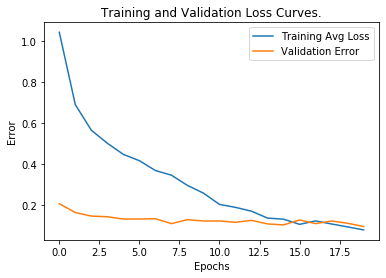

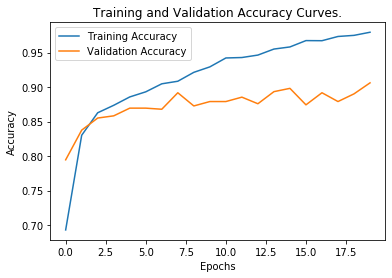

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
Epochs = 20
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.0002, momentum=0.9)

ResNet_Curves = [[],[],[],[]]

Train(resnet18, "resnet18_focalLoss1.pth", Epochs, ResNet_Curves, focalLoss = False)
PlotCurves(ResNet_Curves)

resnet18.to("cpu")

After FC Layers Fine Tunning the Accuracy is 89.81%
F1 Score =  [0.6        0.93726937 0.88036117]
Confusion Matrix


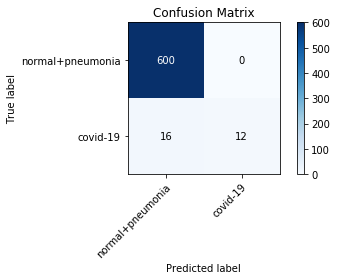

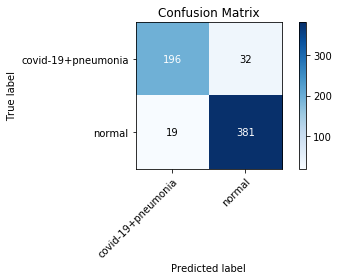

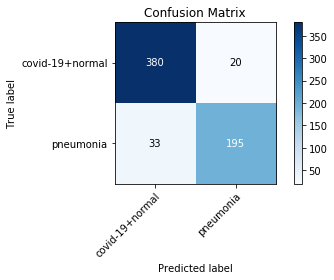

In [18]:
acc, predictions, grndTruth = Accuracy(resnet18, valloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu"), average=None))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")
torch.cuda.empty_cache()



After FC Layers Fine Tunning the Accuracy is 98.23%
F1 Score =  [0.78466077 0.99600599 0.99202552]
Confusion Matrix


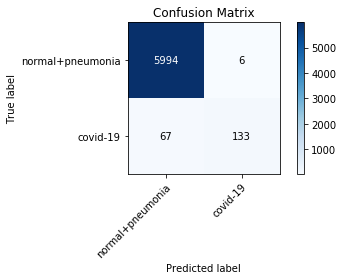

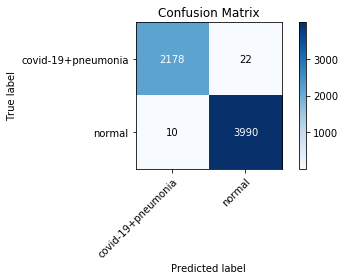

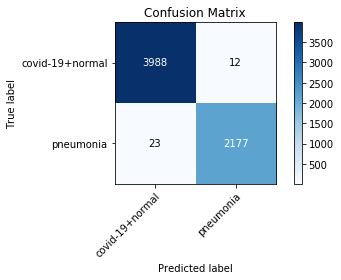

In [19]:
acc, predictions, grndTruth = Accuracy(resnet18, trainloader)
print("After FC Layers Fine Tunning the Accuracy is %.2f%%" % (100*acc))
print("F1 Score = ", f1_score(grndTruth.to("cpu"), predictions.to("cpu"), average=None))
plot_confusion_matrix(grndTruth.to("cpu").numpy(), predictions.to("cpu").numpy(), class_names)

resnet18.to("cpu")
torch.cuda.empty_cache()



In [8]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path



def Predict(Model, dataLoader):
    
    Model.to(device)
    predictions = []
    image_names = []
    
    with torch.no_grad():
        with notebook.tqdm(dataLoader , leave=False, desc="Predicting ", mininterval=0.5 ) as TI:
            for images,labels, paths in TI:
                
                images = images.to(device)
                
                outputs = Model(images)
                
                predicted = (torch.sigmoid(outputs.data) >= 0.5) * 1
                predictions.append(predicted)
                
                image_names += [p[37:] for p in paths]
                
        
    return torch.cat(predictions), image_names

In [9]:
vgg16 = models.vgg16()

features = list(vgg16.classifier.children())[:-1]

num_features = vgg16.classifier[3].out_features

features.extend([nn.Linear(num_features, len(class_names), bias=True)])

vgg16.classifier = nn.Sequential(*features)
vgg16.load_state_dict(torch.load("vgg16_focal_loss.pth"))

<All keys matched successfully>

In [10]:
test_data = ImageFolderWithPaths(data_dir + '/Test',  transform = img_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=True)

pred, Img_names = Predict(vgg16, testloader)
sum(pred[:,0])

tensor(23, device='cuda:0')

In [12]:
pred = pred.to("cpu")
TP = {"Image Names":Img_names, "COVID-19":pred[:,0], "Pneumonia":pred[:,2], "Normal":pred[:,1] }
TP = pd.DataFrame.from_dict(TP)
TP.to_csv("vgg16_focal_loss_TestPredictions.csv", index=False)
TP

,Image Names,COVID-19,Pneumonia,Normal
0,16.png,0,0,1
1,2.png,0,1,0
2,18.png,0,1,0
3,628.png,0,0,1
4,545.png,0,1,0
...,...,...,...,...
624,493.png,0,0,1
625,435.png,0,0,1
626,497.png,0,0,1
627,166.png,0,0,1


In [96]:
sum(pred[:,0])

tensor(22, device='cuda:0')

In [101]:
trainloader.sampler.num_samples

6200